In [1]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2))) # plotting
suppressPackageStartupMessages(suppressWarnings(library(dplyr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(argparser))) # command line arguments
suppressPackageStartupMessages(suppressWarnings(library(patchwork))) # plot patchwork
suppressPackageStartupMessages(suppressWarnings(library(reshape2))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(ggridges))) # ridgeline plots
suppressPackageStartupMessages(suppressWarnings(library(RColorBrewer))) # color palettes
suppressPackageStartupMessages(suppressWarnings(library(cowplot))) # ggplot2 drawing


source("../../utils/figure_themes.r")


In [2]:
model_name <- "MultiClass_MLP"
cell_type <- "PBMC"

## Probabilities

In [3]:
# load in the probabilities
treatment_holdout_probabilities_path <- file.path(
    paste0(
        "../../../4.sc_Morphology_Neural_Network_MLP_Model/results/Multi_Class/",model_name,"/",cell_type,"/probabilities.parquet"
    )
)
# read in the data from the parquet file
probabilities <- arrow::read_parquet(
    treatment_holdout_probabilities_path
)
head(probabilities,2)

apoptosis_prob,control_prob,pyroptosis_prob,label_true,label_pred,data_split,shuffle,class_name,index,Metadata_cell_type,⋯,Metadata_Treatment,Metadata_Dose,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cytoplasm_AreaShape_BoundingBoxMaximum_X,Metadata_Cytoplasm_AreaShape_BoundingBoxMaximum_Y,Metadata_Cytoplasm_AreaShape_BoundingBoxMinimum_X,Metadata_Cytoplasm_AreaShape_BoundingBoxMinimum_Y,Metadata_Site,labels
<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<lgl>,<chr>,<dbl>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.057885949,0.7409405,0.2011736,1,1,train,FALSE,healthy,6135062,PBMC,⋯,LPS_Nigericin,1.000_µg_per_ml_10.000_µM,1493.54472,2062.1328,1507,2074,1484,2050,16,pyroptosis
0.003964022,0.4949294,0.5011066,2,2,train,FALSE,pyroptosis,5358238,PBMC,⋯,Thapsigargin,1.000_µM,10.07292,510.1944,20,521,2,501,10,apoptosis


In [4]:
unique(probabilities$data_split)
unique(probabilities$shuffle)

[1] "train"             "validation"        "testing"          
[4] "treatment_holdout" "holdout"

[1] FALSE  TRUE

In [5]:
# replace label_true value 1 with Control
probabilities$label_true <- gsub("1", "Control", probabilities$label_true)
# replace label_true value 2 with pyroptosis
probabilities$label_true <- gsub("2", "Pyroptosis", probabilities$label_true)
# replace label_true value 0 with apoptosis
probabilities$label_true <- gsub("0", "Apoptosis", probabilities$label_true)

# replace label_pred value 1 with Control
probabilities$label_pred <- gsub("1", "Control", probabilities$label_pred)
# replace label_pred value 2 with pyroptosis
probabilities$label_pred <- gsub("2", "Pyroptosis", probabilities$label_pred)
# replace label_pred value 0 with apoptosis
probabilities$label_pred <- gsub("0", "Apoptosis", probabilities$label_pred)

# replace shuffled value TRUE with Shuffled
probabilities$shuffle <- gsub("TRUE", "Shuffled", probabilities$shuffle)
# replace shuffled value FALSE with Not Shuffled
probabilities$shuffle <- gsub("FALSE", "Not Shuffled", probabilities$shuffle)

# replace data_split value treatment_holdout with Treatment Holdout
probabilities$data_split <- gsub("treatment_holdout", "Treatment holdout", probabilities$data_split)
# remove treatment holdout rows
probabilities <- probabilities[!grepl("Treatment holdout", probabilities$data_split),]
# replace data_split value holdout with Holdout
probabilities$data_split <- gsub("holdout", "Holdout well", probabilities$data_split)
# replace training value train with Training
probabilities$data_split <- gsub("train", "Training", probabilities$data_split)
# replace testing value test with Testing
probabilities$data_split <- gsub("testing", "Testing", probabilities$data_split)
# replace validation value validation with Validation
probabilities$data_split <- gsub("validation", "Validation", probabilities$data_split)


In [6]:
head(probabilities, 2)
unique(probabilities$shuffle)

apoptosis_prob,control_prob,pyroptosis_prob,label_true,label_pred,data_split,shuffle,class_name,index,Metadata_cell_type,⋯,Metadata_Treatment,Metadata_Dose,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cytoplasm_AreaShape_BoundingBoxMaximum_X,Metadata_Cytoplasm_AreaShape_BoundingBoxMaximum_Y,Metadata_Cytoplasm_AreaShape_BoundingBoxMinimum_X,Metadata_Cytoplasm_AreaShape_BoundingBoxMinimum_Y,Metadata_Site,labels
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.057885949,0.7409405,0.2011736,Control,Control,Training,Not Shuffled,healthy,6135062,PBMC,⋯,LPS_Nigericin,1.000_µg_per_ml_10.000_µM,1493.54472,2062.1328,1507,2074,1484,2050,16,pyroptosis
0.003964022,0.4949294,0.5011066,Pyroptosis,Pyroptosis,Training,Not Shuffled,pyroptosis,5358238,PBMC,⋯,Thapsigargin,1.000_µM,10.07292,510.1944,20,521,2,501,10,apoptosis


[1] "Not Shuffled" "Shuffled"

In [7]:
unique(probabilities$data_split)

# change the label columns to be factors
probabilities$label_true <- factor(probabilities$label_true , levels = c(
    "Control", "Apoptosis", "Pyroptosis"
))
probabilities$label_pred <- factor(probabilities$label_pred , levels = c(
    "Pyroptosis", "Apoptosis", "Control"
))
# change the data_split column to be a factor
probabilities$data_split <- factor(probabilities$data_split, levels = c(
    "Training", "Validation", "Testing", "Holdout well"
))
# change the shuffled_data column to be a factor
probabilities$shuffle <- factor(probabilities$shuffle, levels = c(
    "Not Shuffled", "Shuffled"
))

unique(probabilities$data_split)

[1] "Training"     "Validation"   "Testing"      "Holdout well"

[1] Training     Validation   Testing      Holdout well
Levels: Training Validation Testing Holdout well

### Patch the individual facet grids together for a figure sub-panel

Picking joint bandwidth of 0.00991

Picking joint bandwidth of 0.0131

Picking joint bandwidth of 0.00937

Picking joint bandwidth of 0.0101

Picking joint bandwidth of 0.00333

Picking joint bandwidth of 0.0274

Picking joint bandwidth of 0.0153

Picking joint bandwidth of 0.0081

Picking joint bandwidth of 0.00765

Picking joint bandwidth of 0.0102

Picking joint bandwidth of 0.0073

Picking joint bandwidth of 0.00799

Picking joint bandwidth of 0.00391

Picking joint bandwidth of 0.0393

Picking joint bandwidth of 0.00798

Picking joint bandwidth of 0.0159



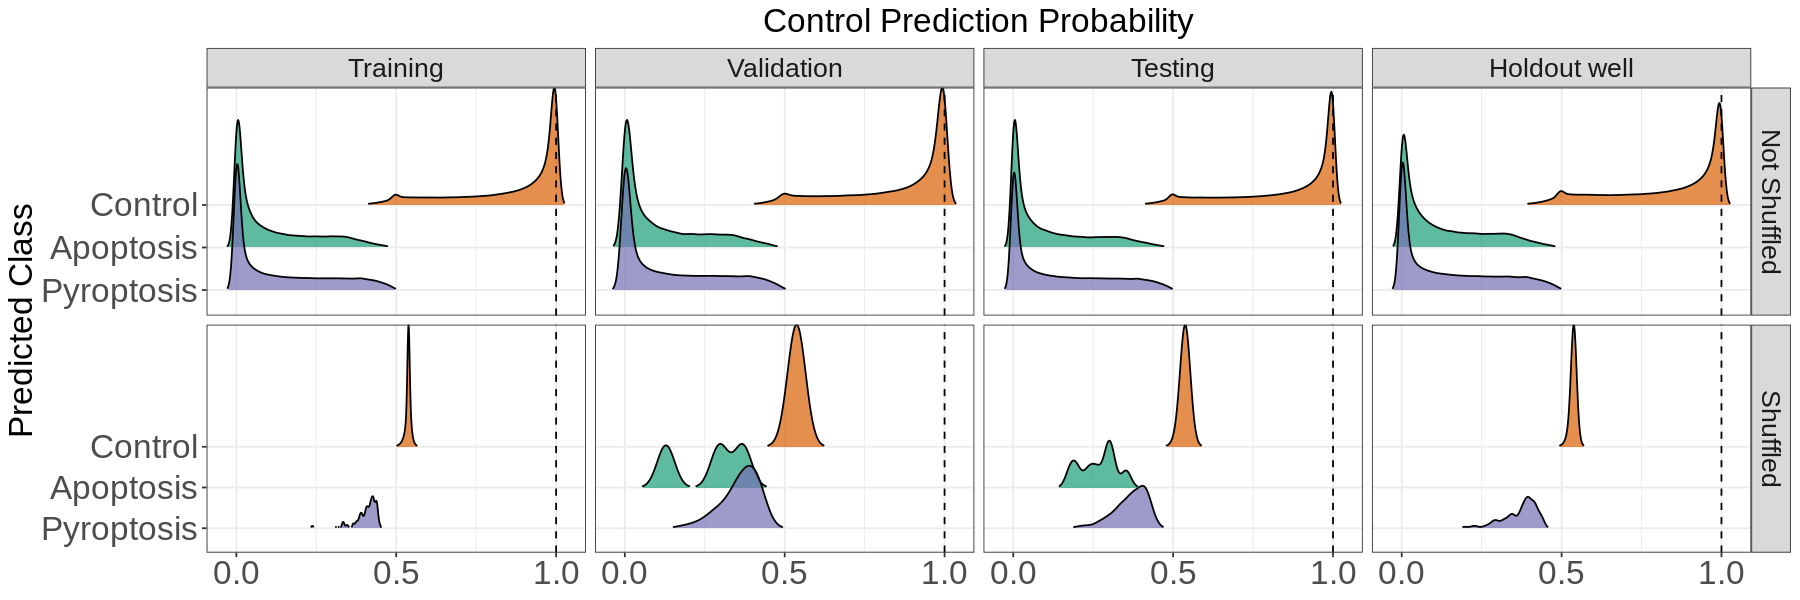

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Picking joint bandwidth of 0.0102

Picking joint bandwidth of 0.0135

Picking joint bandwidth of 0.00976

Picking joint bandwidth of 0.0105

Picking joint bandwidth of 0.00464

Picking joint bandwidth of 0.0213

Picking joint bandwidth of 0.0119

Picking joint bandwidth of 0.0199



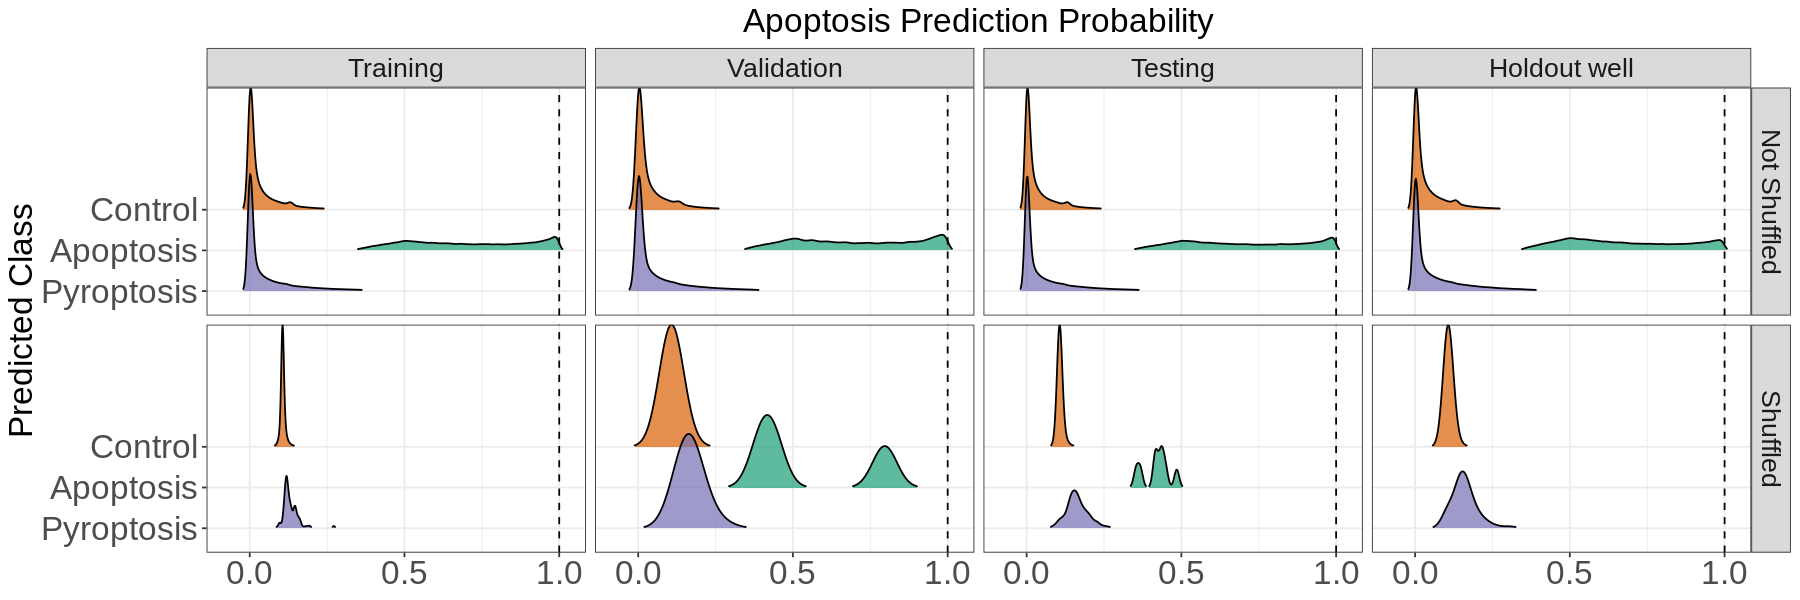

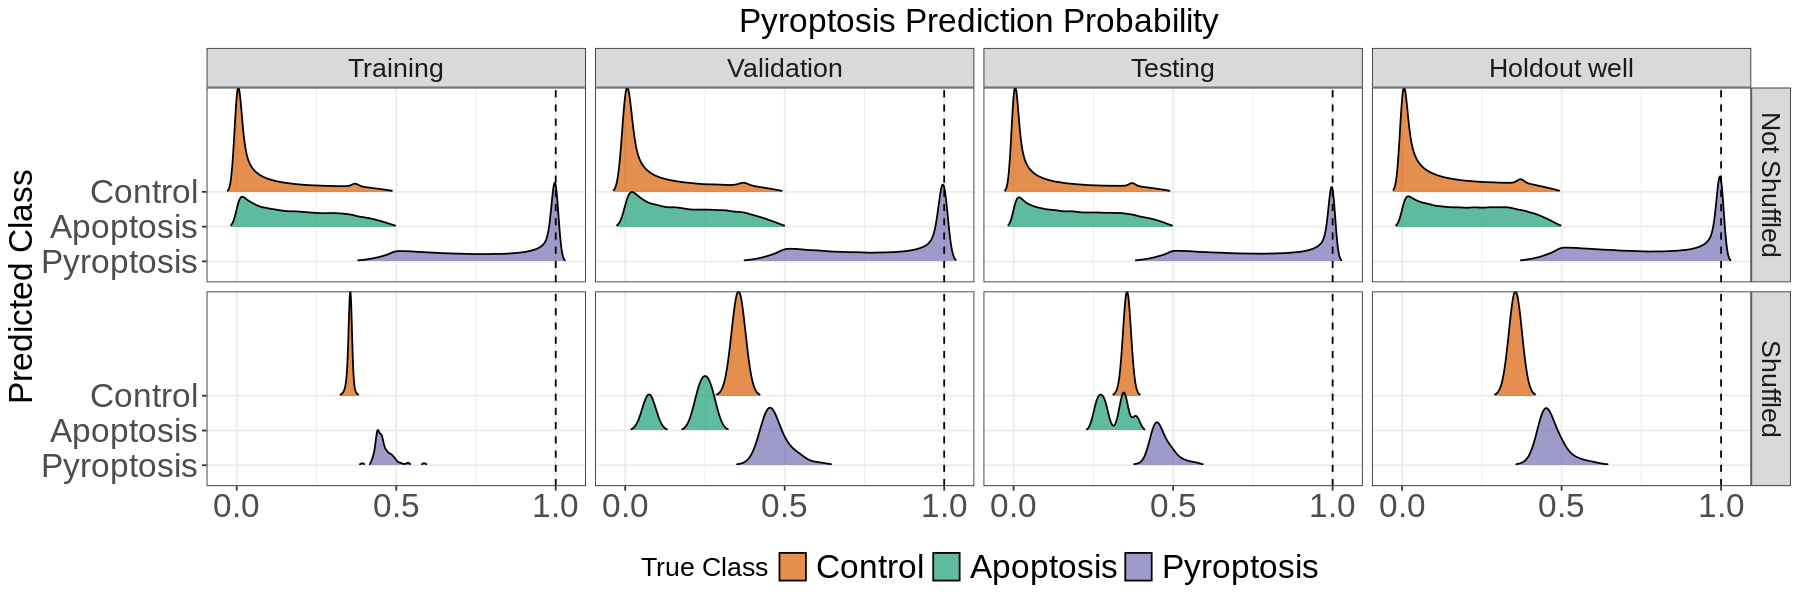

In [8]:
height <- 5
width <- 15
options(repr.plot.width = width, repr.plot.height = height)
ridge_plot_control <- (
    ggplot(probabilities, aes(x = control_prob, y = label_pred, fill = label_true, group = label_pred))
    + geom_density_ridges(
        aes(fill = label_pred), alpha = 0.7, scale = 3, rel_min_height = 0.01
    )
    # change color of the density ridges
    + scale_fill_manual(values = c(
        "Control" = brewer.pal(3, "Dark2")[2],
        "Apoptosis" = brewer.pal(3, "Dark2")[1],
        "Pyroptosis" = brewer.pal(3, "Dark2")[3]
    ))
    

    + facet_grid(shuffle~data_split, scales = "free_y")
    + geom_vline(xintercept = 1, linetype = "dashed", color = "black")
    + scale_x_continuous(breaks = seq(0, 1, 0.5))
    + labs(title = "Control Prediction Probability", y = "Predicted Class",fill = "True Class")
    + labs()
    + theme_bw()
    + figure_theme
    # no legend
    + theme(legend.position = "none")
    + theme(plot.title = element_text(size = 20, hjust = 0.5))
    # remove x axis label
    + theme(axis.title.x = element_blank())
)
ridge_plot_control


ridge_plot_apoptosis <- (
    ggplot(probabilities, aes(x = apoptosis_prob, y = label_pred, fill = label_true, group = label_pred))
    + geom_density_ridges(
        aes(fill = label_pred), alpha = 0.7, scale = 3, rel_min_height = 0.01
    )
    + scale_fill_manual(values = c(
        "Control" = brewer.pal(3, "Dark2")[2],
        "Apoptosis" = brewer.pal(3, "Dark2")[1],
        "Pyroptosis" = brewer.pal(3, "Dark2")[3]
    ))
    + geom_vline(xintercept = 1, linetype = "dashed", color = "black")
    + facet_grid(shuffle~data_split, scales = "free_y")
    + scale_x_continuous(breaks = seq(0, 1, 0.5))
    + labs(title = "Apoptosis Prediction Probability", y = "Predicted Class",fill = "True Class")
    + labs()
    + theme_bw()
    + figure_theme
    # remove legend
    + theme(legend.position = "none")
    + theme(plot.title = element_text(size = 20, hjust = 0.5))
    # remove x axis label   
    + theme(axis.title.x = element_blank())
)
ridge_plot_apoptosis

ridge_plot_pyroptosis <- (
    ggplot(probabilities, aes(x = pyroptosis_prob, y = label_pred, fill = label_true, group = label_pred))
    + geom_density_ridges(
        aes(fill = label_pred), alpha = 0.7, scale = 3, rel_min_height = 0.01
    )
    + scale_fill_manual(values = c(
        "Control" = brewer.pal(3, "Dark2")[2],
        "Apoptosis" = brewer.pal(3, "Dark2")[1],
        "Pyroptosis" = brewer.pal(3, "Dark2")[3]
    ))
    + geom_vline(xintercept = 1, linetype = "dashed", color = "black")
    + facet_grid(shuffle~data_split, scales = "free_y")+ scale_x_continuous(breaks = seq(0, 1, 0.5))
    + scale_x_continuous(breaks = seq(0, 1, 0.5))
    + labs(title = "Pyroptosis Prediction Probability", y = "Predicted Class",fill = "True Class")
    + labs()
    + theme_bw()
    + figure_theme
    # make title larger
    + theme(plot.title = element_text(size = 20, hjust = 0.5))
    + theme(legend.position = "bottom", legend.direction = "horizontal")
    # remove x axis label
    + theme(axis.title.x = element_blank())
    # add vertical line at 1 
    # change legend label order
    + guides(fill = guide_legend(reverse = TRUE))
)
ridge_plot_pyroptosis


### Patch the individual facet grids together for a figure sub-panel

In [9]:
# if dir does not exist create it
if(!dir.exists("../figures")){
    dir.create("../figures")
}

Picking joint bandwidth of 0.00991

Picking joint bandwidth of 0.0131

Picking joint bandwidth of 0.00937

Picking joint bandwidth of 0.0101

Picking joint bandwidth of 0.00333

Picking joint bandwidth of 0.0274

Picking joint bandwidth of 0.0153

Picking joint bandwidth of 0.0081

Picking joint bandwidth of 0.00765

Picking joint bandwidth of 0.0102

Picking joint bandwidth of 0.0073

Picking joint bandwidth of 0.00799

Picking joint bandwidth of 0.00391

Picking joint bandwidth of 0.0393

Picking joint bandwidth of 0.00798

Picking joint bandwidth of 0.0159

Picking joint bandwidth of 0.0102

Picking joint bandwidth of 0.0135

Picking joint bandwidth of 0.00976

Picking joint bandwidth of 0.0105

Picking joint bandwidth of 0.00464

Picking joint bandwidth of 0.0213

Picking joint bandwidth of 0.0119

Picking joint bandwidth of 0.0199

Picking joint bandwidth of 0.00991

Picking joint bandwidth of 0.0131

Picking joint bandwidth of 0.00937

Picking joint bandwidth of 0.0101

Picking j

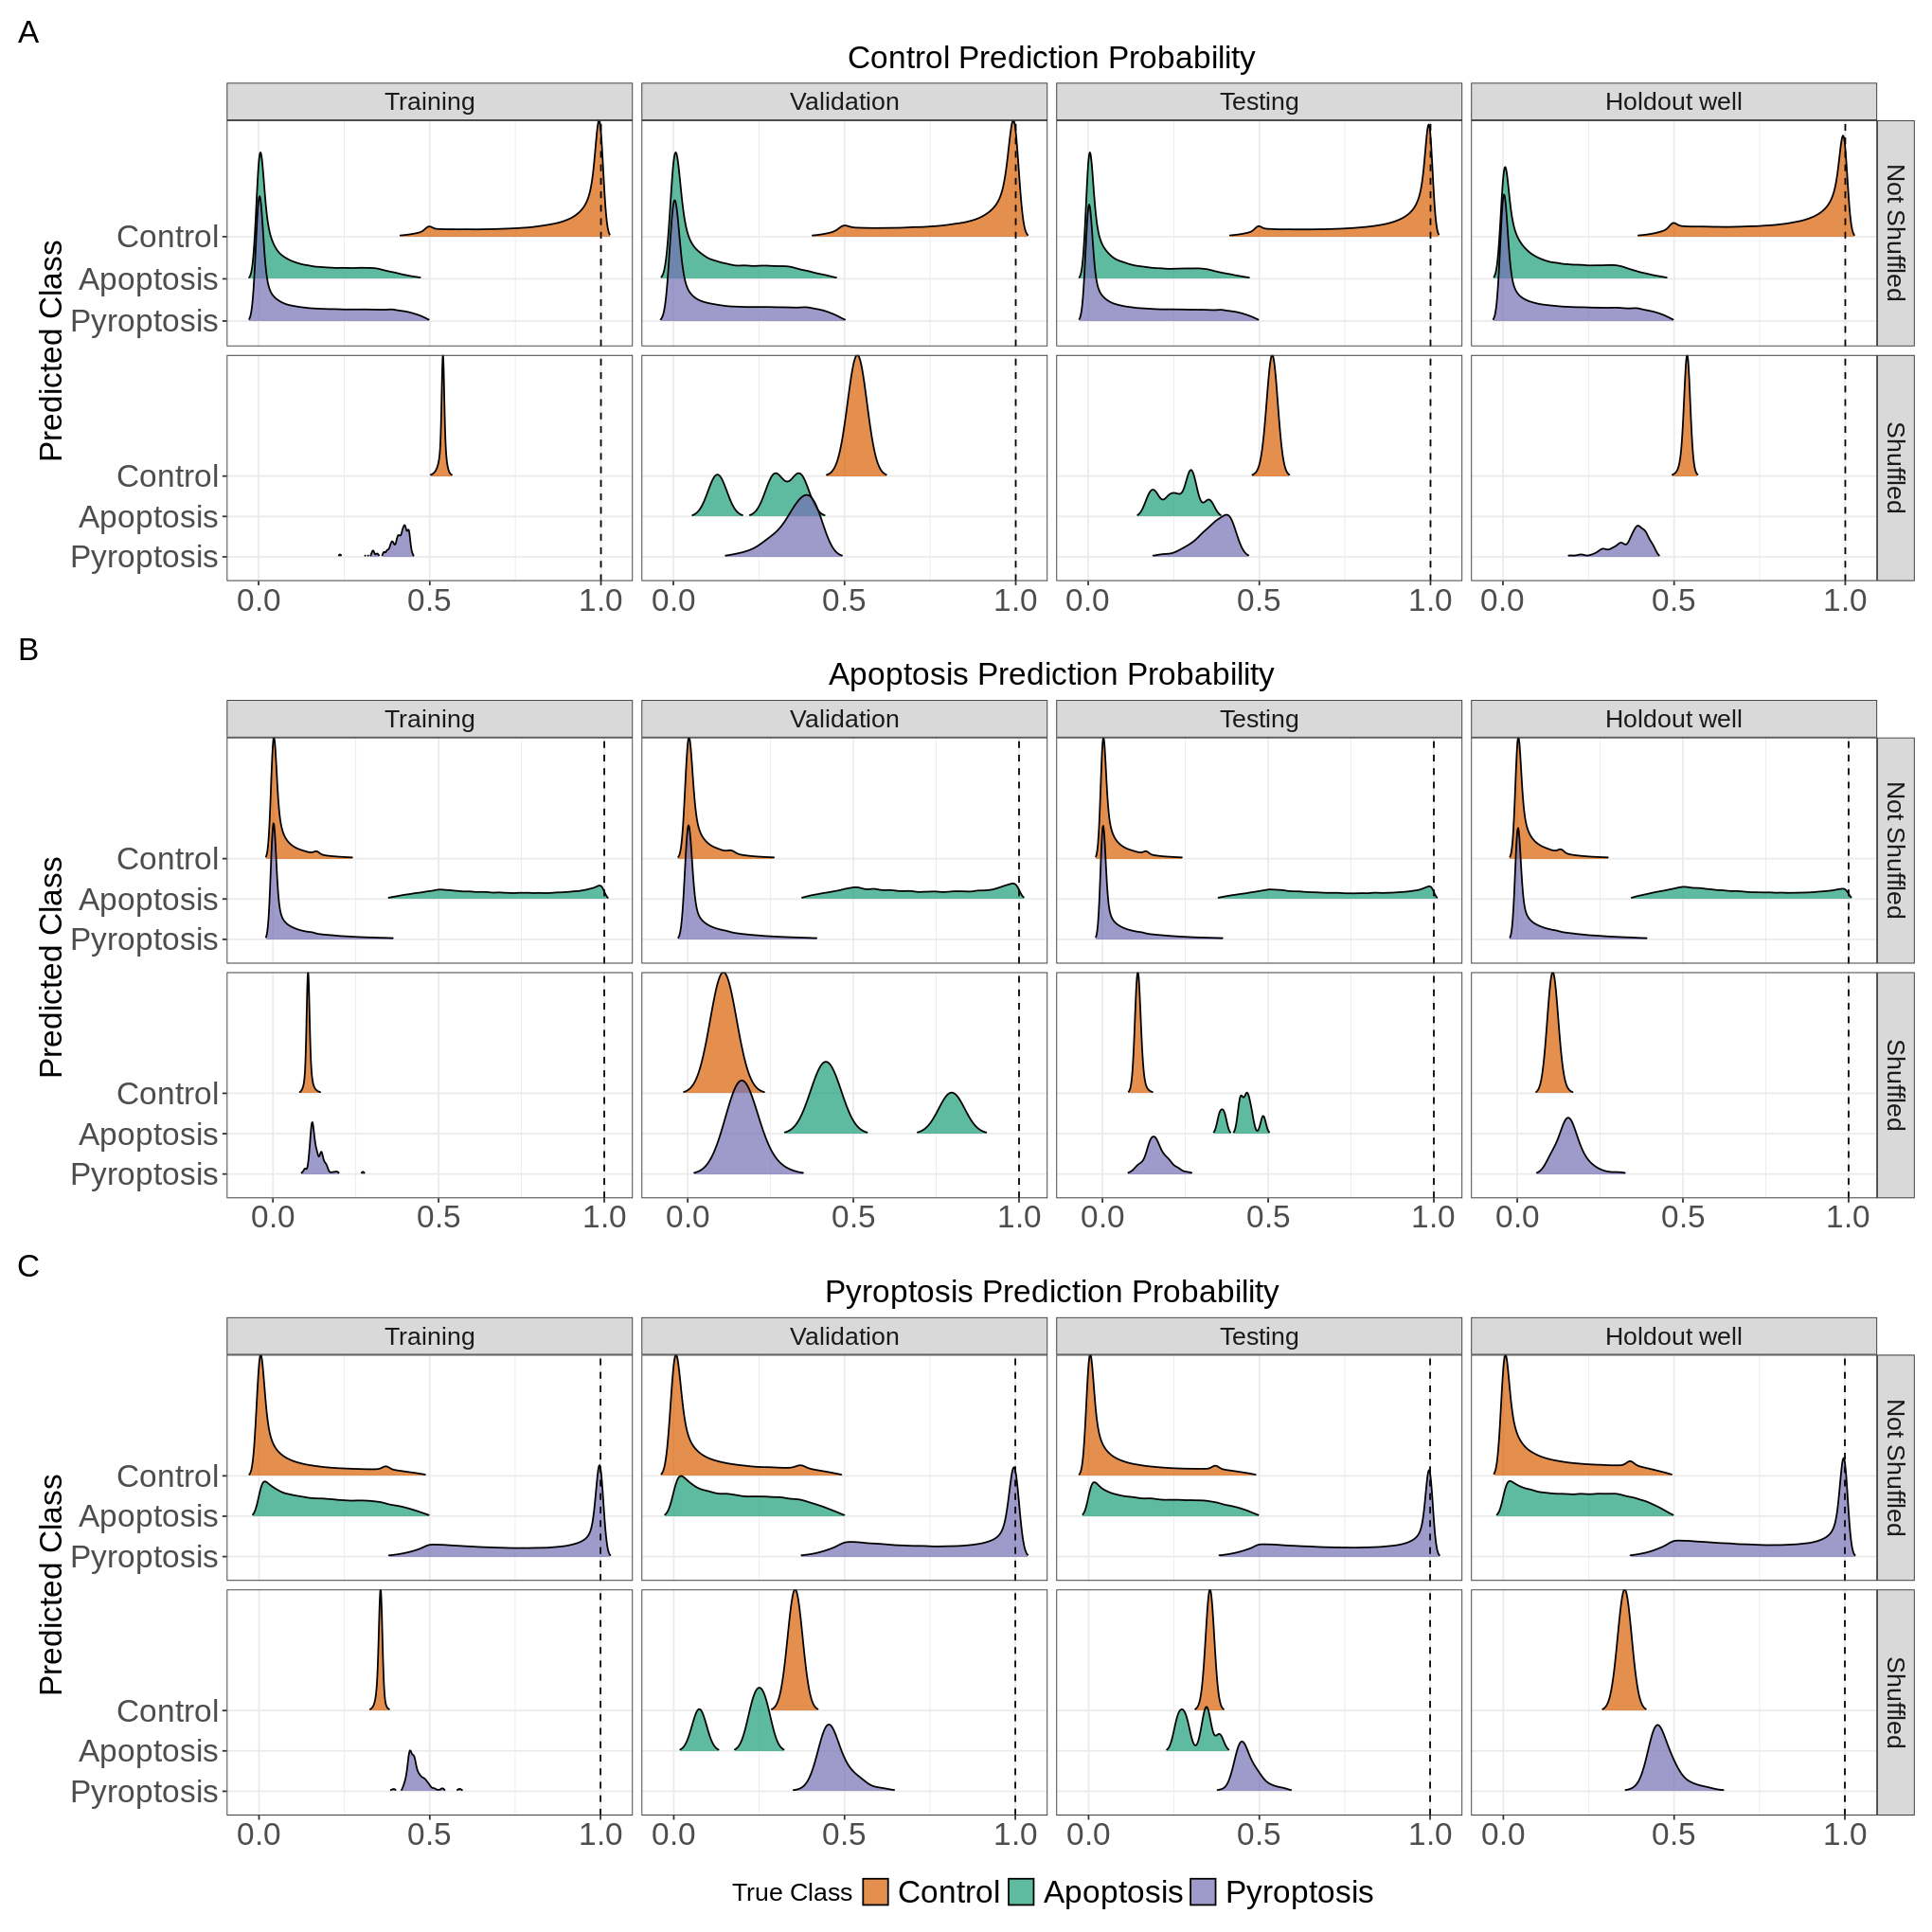

In [10]:
# patch the plots together via the patchwork package
layout <- c(
    area(t=1, b=2, l=1, r=1), # A
    area(t=3, b=4, l=1, r=1), # B
    area(t=5, b=6, l=1, r=1)  # C
)
# set plot size
width <- 17
height <- 17
options(repr.plot.width=width, repr.plot.height=height, units = "cm", dpi = 600)
figS12 <- (
    ridge_plot_control
    + ridge_plot_apoptosis
    + ridge_plot_pyroptosis
    + plot_layout(design = layout)
    + plot_annotation(tag_levels = "A") &  theme(plot.tag = element_text(size = 20))
)
figS12
# save the plot
ggsave(
    filename = paste0("../figures/","S12",".png"),
    plot = figS12,
    width = width,
    height = height,
    units = "in",
    dpi = 600
)